# Задание по программированию: 
# Дифференциально экспрессированные гены
### Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Задание: сравнение уровня экспрессии генов в группах больных и здоровых людей. В результате такого анализа мы получим набор генов, в которых экспрессия значимо отличается в подвыборке больных и в подвыборке здоровых людей. В последствии мы сможем использовать эту информацию для того, чтобы создать диагностическую систему, которая позволит врачу быстрее, дешевле, точнее определить, есть ли данное заболевание у пациента, который к нему пришел на прием, насколько оно серьезное, опять же какую терапию ему можно будет ему назначить.

## Описание используемых данных
Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.
В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

In [1]:
import pandas as pd
import scipy as sc
import seaborn as sb

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv("gene_high_throughput_sequencing.csv",sep=',')
data.head(3)

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597


In [5]:
print(data.shape)

(72, 15750)


In [6]:
print(data.Diagnosis.value_counts())

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64


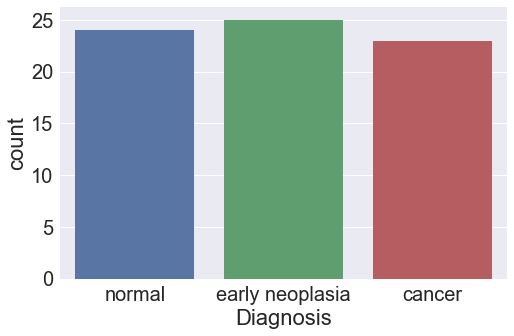

In [7]:
figure(figsize=(8, 5))
sb.set(font_scale=2)
sb.countplot(x="Diagnosis", data=data)

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей. Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

## Необходимо
1. Определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.
2. Оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

## Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. 
В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:
\begin{equation*}
F_c(C,T) = \begin{cases} 
           \frac{T}{C}, \quad T>C \\
           -\frac{C}{T}, \quad T<C
           \end{cases}
\end{equation*}

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

## Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:
1. для групп normal (control) и early neoplasia (treatment)
2. для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости (= 0.05).

In [8]:
NM=data[data.Diagnosis == 'normal']
EN=data[data.Diagnosis == 'early neoplasia']
CN=data[data.Diagnosis == 'cancer']
pvalues_1=[]; pvalues_2=[]; a=0; b=0; statmean_1=0; statmean_2=0;
for i in range(2,15750):
    a = sc.stats.ttest_ind(NM.iloc[:,i],EN.iloc[:,i],equal_var=False).pvalue; pvalues_1.append(a)
    b = sc.stats.ttest_ind(EN.iloc[:,i],CN.iloc[:,i],equal_var=False).pvalue; pvalues_2.append(b)

In [13]:
print(sum(np.array(pvalues_1) < 0.05), sum(np.array(pvalues_2) < 0.05))

1575 3490


## Часть 2: поправка методом Холма

In [14]:
import statsmodels.stats.multitest as smm

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

In [15]:
reject_1, p_corrected_1, _, _ = smm.multipletests(pvalues_1, alpha = 0.05/2, method = 'holm') 
reject_2, p_corrected_2, _, _ = smm.multipletests(pvalues_2, alpha = 0.05/2, method = 'holm') 

In [17]:
print("Без учёта практической значимости :", np.sum(reject_1),',', np.sum(reject_2))

Без учёта практической значимости : 2 , 79


In [18]:
def fold_change(T,C):
    if T>C:
        return T/C
    else:
        return -C/T

In [64]:
statmean_1=0; statmean_2=0;
for i in np.where(reject_1==1)[0]:
    T=NM.iloc[:,i+2].mean();
    C=EN.iloc[:,i+2].mean();
    fc=fold_change(T,C);
    if abs(fc)>1.5:
        statmean_1+=1;
for i in np.where(reject_2==1)[0]:
    T=EN.iloc[:,i+2].mean();
    C=CN.iloc[:,i+2].mean();
    fc=fold_change(T,C);
    if abs(fc)>1.5:
        statmean_2+=1;
print "С учётом практической значимости :", statmean_1,',',statmean_2

С учётом практической значимости : 2 , 77


## Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [65]:
reject_1, p_corrected_1, _, _ = smm.multipletests(pvalues_1, alpha = 0.05/2, method = 'fdr_bh') 
reject_2, p_corrected_2, _, _ = smm.multipletests(pvalues_2, alpha = 0.05/2, method = 'fdr_bh') 

In [66]:
print "Без учёта практической значимости :", np.sum(reject_1),',', np.sum(reject_2)

Без учёта практической значимости : 4 , 832


In [67]:
statmean_1=0; statmean_2=0;
for i in np.where(reject_1==1)[0]:
    T=NM.iloc[:,i+2].mean();
    C=EN.iloc[:,i+2].mean();
    fc=fold_change(T,C);
    if abs(fc)>1.5:
        statmean_1+=1;
for i in np.where(reject_2==1)[0]:
    T=EN.iloc[:,i+2].mean();
    C=CN.iloc[:,i+2].mean();
    fc=fold_change(T,C);
    if abs(fc)>1.5:
        statmean_2+=1;
print "С учётом практической значимости :", statmean_1,',',statmean_2

С учётом практической значимости : 4 , 524
